# Code for gaussian benchmark baselines

## 1. Imports

In [1]:
from eot_benchmark.gaussian_mixture_benchmark import (
    get_guassian_mixture_benchmark_sampler,
    get_guassian_mixture_benchmark_ground_truth_sampler, 
)

from eot_benchmark.metrics import compute_BW_UVP_by_gt_samples, calculate_gm_benchmark_normalized_mmd

In [2]:
import math
import gc
import wandb
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

In [3]:
gc.collect(); torch.cuda.empty_cache()

## 2. Config

In [4]:
DIM = 16
EPS = 1
assert DIM > 1

L1 = 1e-10
GPU_DEVICE = 1
EPSILON = EPS
BATCH_SIZE = 32

SEED = 42
MAX_STEPS = 2000
METRICS_INTERVAL = 500
CONTINUE = -1

In [5]:
EXP_NAME = f'Gaussians_identity_baseline_EPSILON_{EPSILON}_DIM_{DIM}'

config = dict(
    DIM=DIM,
    EPSILON=EPSILON,
    SEED=SEED,
    MAX_STEPS=MAX_STEPS,
)

In [6]:
# assert torch.cuda.is_available()
# torch.cuda.set_device(GPU_DEVICE)

## 3. Initialize Benchmark

In [7]:
torch.manual_seed(SEED); np.random.seed(SEED);
X_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPS,
                                           batch_size=BATCH_SIZE, device="cpu", download=True)
Y_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPS,
                                          batch_size=BATCH_SIZE, device="cpu", download=False)

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=DIM, eps=EPS,
                                                                                batch_size=BATCH_SIZE, 
                                                                                device="cpu",
                                                                                download=False)

Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /root/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████| 75.3k/75.3k [00:00<00:00, 2.05MB/s]


In [8]:
pca = PCA(n_components=2)

samples = X_sampler.sample(10000)
samples = samples.cpu()

target_samples = Y_sampler.sample(10000)
target_samples = target_samples.cpu()

pca.fit(torch.cat((samples, target_samples)))

PCA(n_components=2)

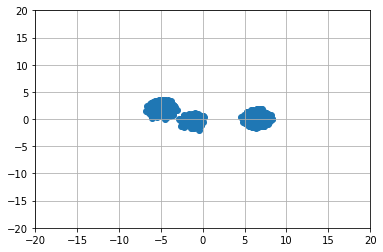

In [9]:
samples_pca = pca.transform(samples)

plt.scatter(samples_pca[:, 0], samples_pca[:, 1])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

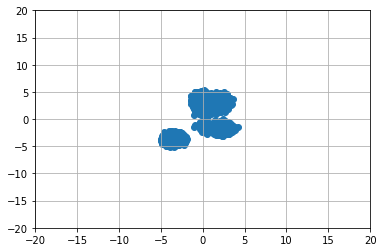

In [10]:
target_samples_pca = pca.transform(target_samples)
plt.scatter(target_samples_pca[:, 0], target_samples_pca[:, 1])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

## 4. Model initialization

In [11]:
class IdentityBaseline(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [12]:
model = IdentityBaseline()

## 5. Training

In [13]:
wandb.init(name=EXP_NAME, config=config, project='SchrodingerBridge')

wandb: Currently logged in as: schrodinger_bridge (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
torch.manual_seed(SEED); np.random.seed(SEED)

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    model.train()
    
    if step % METRICS_INTERVAL == 0:
        model.eval()
        # metrics
        with torch.no_grad():
            # bw-uvp
            X = X_sampler.sample(100000)
            Y = Y_sampler.sample(100000)
            XN = model(X)
            
            X0_gt, XN_gt = ground_truth_plan_sampler.sample(100000)
            X0_XN_gt = torch.cat((X0_gt, XN_gt), dim=1)
            X0_XN = torch.cat((X, XN), dim=1)
            
            bw_uvp_target = compute_BW_UVP_by_gt_samples(XN.cpu().numpy(), Y.cpu().numpy())
            bw_uvp_plan = compute_BW_UVP_by_gt_samples(X0_XN.cpu().numpy(), X0_XN_gt.cpu().numpy())
            
            # mmd
            X = X_sampler.sample(10000)
            Y = Y_sampler.sample(10000)
            XN = model(X)
            
            X0_gt, XN_gt = ground_truth_plan_sampler.sample(10000)
            X0_XN_gt = torch.cat((X0_gt, XN_gt), dim=1)
            X0_XN = torch.cat((X, XN), dim=1)
            
            mmd_plan = calculate_gm_benchmark_normalized_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS)
            mmd_target = calculate_gm_benchmark_normalized_mmd(XN, Y, dim=DIM, eps=EPS)
            
            wandb.log({f'BW-UVP_target' : bw_uvp_target}, step=step)
            wandb.log({f'BW-UVP_plan' : bw_uvp_plan}, step=step)
            wandb.log({f'MMD_target' : mmd_target}, step=step)
            wandb.log({f'MMD_plan' : mmd_plan}, step=step)

    gc.collect(); torch.cuda.empty_cache()

 91%|█████████ | 1813/2000 [02:13<00:13, 14.24it/s]